# Intro

## Standard modules

In [2]:
import os, sys
import pathlib
import requests

In [3]:
import numpy as np

In [4]:
from tqdm.auto import tqdm, trange

In [5]:
from sentence_transformers import util

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [7]:
from sklearn.decomposition import PCA

In [8]:
import seaborn

In [9]:
import pymannkendall as mk

In [117]:
from scipy.spatial.distance import cosine

## Personal modules

In [10]:
from toolbox.updater import time_is_now

In [11]:
from file2text import file2text

In [12]:
from first_rough_cleaning import first_text_cleaner

In [13]:
from file_handler import *

In [14]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [15]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [16]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [17]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/pca_centr_vectors/'

## Witten's vector

In [18]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [19]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

## Load vectors

In [26]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [24]:
vecfiles.sort()

### Goals' vectors

In [30]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [126]:
goalvecfiles.sort()

In [128]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Reports' vectors

In [42]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [61]:
reports_files.sort()

In [45]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [48]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [141]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [142]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

## Increasing trend?

In [91]:
years=years.astype('i4')

### Global

In [148]:
cos_sims_global=np.zeros(len(years), dtype=[('mean', 'f8'), ('all', object)])

In [149]:
for i_y, year in enumerate(tqdm(years)):

    
    cos_sims_global[i_y]['all']=np.array([float(util.cos_sim(goalvecs[-1], vec)) for vec in vectors[vectors['year']==year]['vector']])
    cos_sims_global[i_y]['mean']=np.mean(cos_sims_global[i_y]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

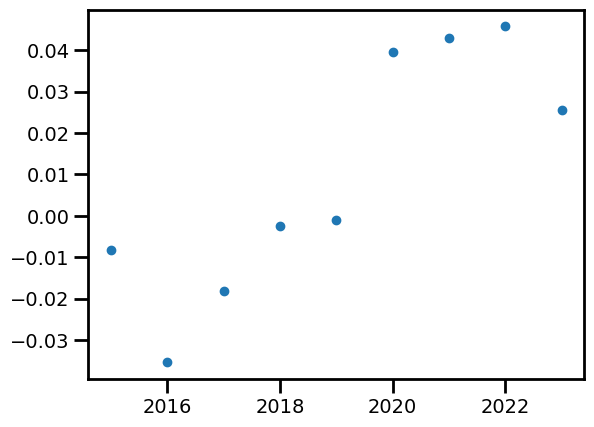

In [151]:
plt.scatter(np.arange(2015, 2024), cos_sims_global['mean'])
plt.show()

In [158]:
type(cos_sims_global['all'])

numpy.ndarray

In [167]:
data_for_seaborn={years[i]:list(_) for i, _ in enumerate(cos_sims_global['all'])}

<Axes: >

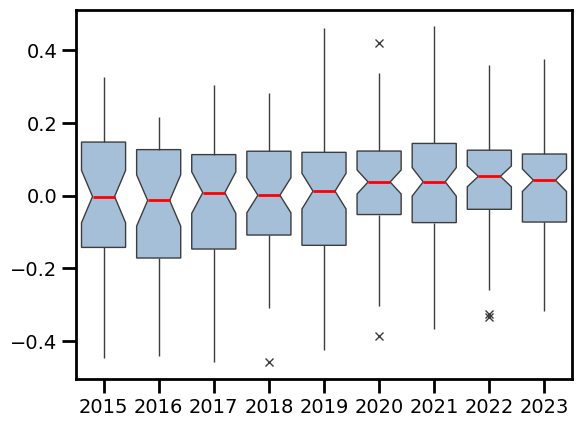

In [168]:
seaborn.boxplot(data=data_for_seaborn, notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2})

Mann-Kendall required?

### By sector

In [170]:
secs, k_secs=np.unique(vectors['sector'], return_counts=True)

In [171]:
np.vstack((secs, k_secs)).T

array([['01', '61'],
       ['02', '82'],
       ['03', '84'],
       ['04', '47'],
       ['05', '52'],
       ['06', '41'],
       ['07', '54'],
       ['08', '49'],
       ['09', '25'],
       ['10', '37'],
       ['11', '41']], dtype='<U21')

In [175]:
cos_sims_by_sec=np.zeros(len(years)*len(secs), dtype=[('year', 'i4'),('sector', 'U2'),('mean', 'f8'), ('all', object)])

In [188]:
for i_y, year in enumerate(tqdm(years)):
    for i_s, sec in enumerate(secs):
        cos_sims_by_sec[i_y*len(secs)+i_s]['year']=year
        cos_sims_by_sec[i_y*len(secs)+i_s]['sector']=sec
        cos_sims_by_sec[i_y*len(secs)+i_s]['all']=np.array([float(util.cos_sim(goalvecs[-1], vec)) for vec in vectors[np.logical_and(vectors['year']==year, vectors['sector']==sec)]['vector']])
        cos_sims_by_sec[i_y*len(secs)+i_s]['mean']=np.mean(cos_sims_by_sec[i_y*len(secs)+i_s]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

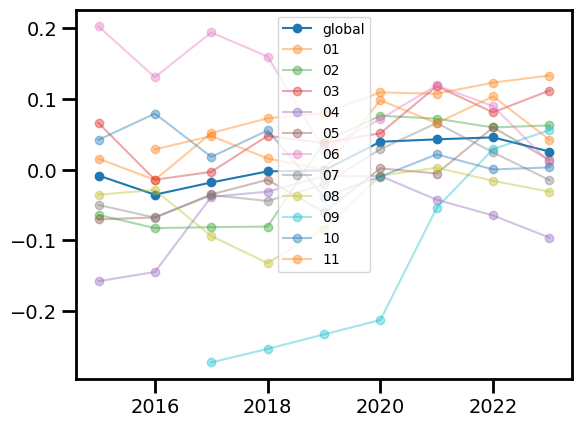

In [193]:
plt.plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
for sec in secs:
    plt.plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec, alpha=0.4)
plt.legend()
plt.show()

Waiting for Mann-Kendall to decide which are the sector to look for something.

## Mann Kendall

### Global

In [159]:
mk.original_test(cos_sims_global['mean'])

Mann_Kendall_Test(trend='increasing', h=True, p=0.00914914757959373, z=2.606430175713435, Tau=0.7222222222222222, s=26.0, var_s=92.0, slope=0.008636303942316109, intercept=-0.03555228317357982)

Mmm, ok...

### By sector

In [204]:
for sec in secs:
    cacca=mk.original_test(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'])
    print(f'sec={sec:}, \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2f}')

sec=01, increasing, p-value=1.23e-03, slope=0.02
sec=02, increasing, p-value=4.76e-02, slope=0.02
sec=03, increasing, p-value=4.76e-02, slope=0.02
sec=04, no trend  , p-value=6.02e-01, slope=0.01
sec=05, increasing, p-value=4.88e-03, slope=0.01
sec=06, decreasing, p-value=2.86e-02, slope=-0.02
sec=07, increasing, p-value=2.86e-02, slope=0.01
sec=08, no trend  , p-value=3.48e-01, slope=0.01
sec=09, increasing, p-value=2.67e-03, slope=0.06
sec=10, no trend  , p-value=2.51e-01, slope=-0.01
sec=11, no trend  , p-value=3.86e-01, slope=0.01


Mmm, ok...